In [12]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
from scipy.interpolate import interp1d

In [28]:
class BG_Calibrater:      #medianフィルター未実装
    '''
    -------------------work flow-------------------
    decide the threshold for outlier(low:depression of mica, high:CNF)
    バックグラウンドのみ抽出
    取り除いた外れ値の部分を線形補完
    savgolフィルターによる近似曲線抽出
    元データ-近似曲線でベースラインの補正
    必要であればメディアンフィルターの適用
    補正後の画像を出力
    （途中で各種のパラメーターを属性として保存）

    -------------------Parameter-------------------
    savgol_window
    savgol_polyorder
    apply_median

    '''
    def __init__(self, savgol_window=31, savgol_polyorder=2, apply_median=True):
        self.savgol_window = savgol_window
        self.savgol_polyorder = savgol_polyorder
        self.apply_median = apply_median

    def __call__(self, original_image):
        '''
        original image is need to be Various_Image class
        Various_Image class is not implemented yet, so 
        '''
        thresholds_low, thresholds_high = self._get_thresholds(original_image)
        #以下のfilterは、ただ中間結果を保持しているだけなので、改善できる気がする
        background_filter = self._get_background_filter(original_image, thresholds_low, thresholds_high)
        background_splined = self._get_splined_background(original_image, background_filter)
        background_smoothed = self._savgol_smoothing(background_splined, self.savgol_window, self.savgol_polyorder)
        calibrated_image = original_image - background_smoothed
        if self.apply_median == True:
            calibrated_image = cv2.medianBlur(calibrated_image.astype(np.float32), ksize=3)
        return calibrated_image


    @staticmethod
    def _get_thresholds(image):      #各行の外れ値の閾値を取得（2次元array）
        weight_q1 = stats.scoreatpercentile(image, 25, axis=1).reshape((image.shape[0], 1))
        weight_q3 = stats.scoreatpercentile(image, 75, axis=1).reshape((image.shape[0], 1))
        weight_iqr = weight_q3 - weight_q1
        thresholds_low = weight_q1 - (weight_iqr) * 1.5
        thresholds_high =  weight_q3 + (weight_iqr)* 0          #*0であってる？
        return thresholds_low, thresholds_high
    
    @staticmethod
    def _get_background_filter(image, thresholds_low, thresholds_high):
        '''
         get the filter to remove the outlier pixel(CNF and depression) from AFM image
        '''
        background_filter = (image > thresholds_low) & (image < thresholds_high)
        background_filter[:,0] = True
        background_filter[:,-1] = True    #画像の端をTrueにしておかないと次の補完でエラーになる
        return background_filter

    @staticmethod
    def _get_splined_background(original_image, background_filter):   #欠損しているバックグラウンドの補完
        splined_bg = np.empty(original_image.shape)
        n_row, n_column = original_image.shape
        for row in range(n_row):
            filter_row = background_filter[row]
            background_x, *_ = np.where(filter_row)
            background_height = original_image[row][filter_row]
            f = interp1d(background_x, background_height)
            x = np.arange(n_column)  #画像の横一列のピクセル番号（0～1023）
            splined_bg[row] = f(x)
        return  splined_bg  

    @staticmethod
    def _savgol_smoothing(background_splined, window_length, polyorder):
        def savgol(row, wl=window_length, po=polyorder):
            return savgol_filter(row, wl, po)
        bg_smoothed = np.apply_along_axis(savgol, 1, background_splined)
        return bg_smoothed
        
        

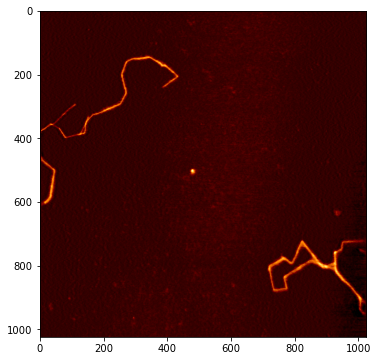

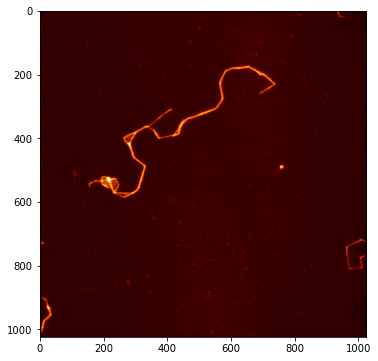

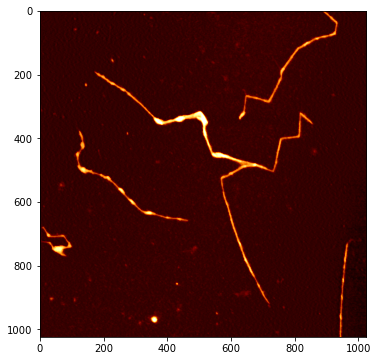

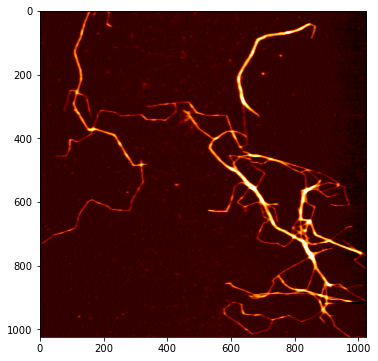

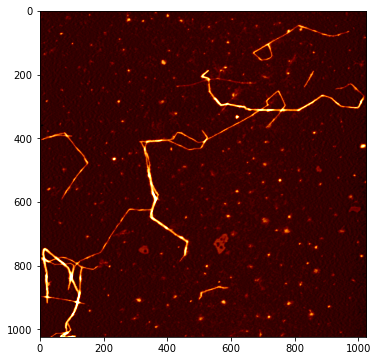

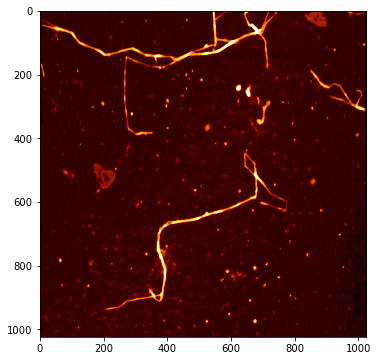

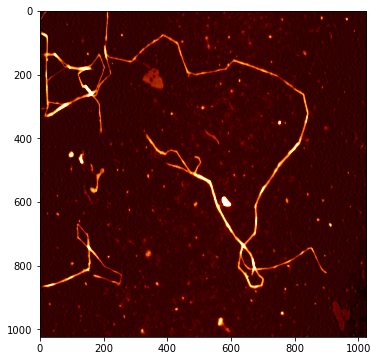

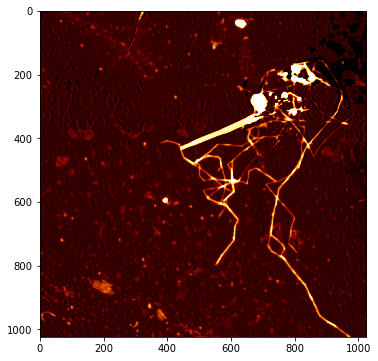

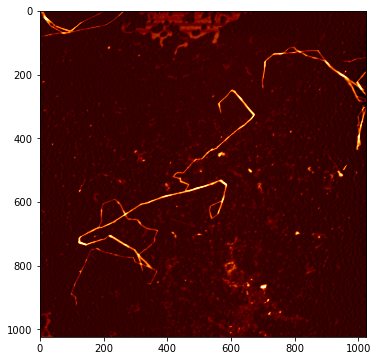

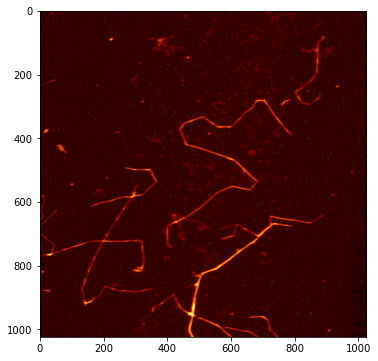

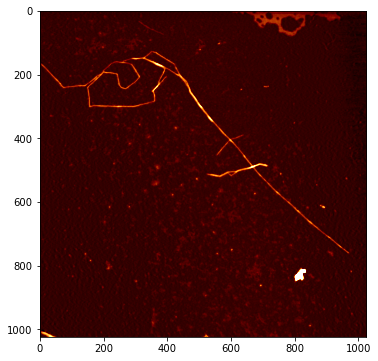

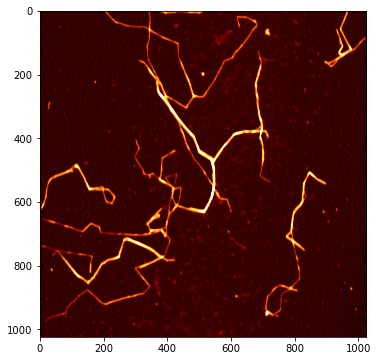

In [30]:
filepath = Path("D:/Python練習/data/mild_oxidization") 
flist = list(filepath.glob('*.txt'))
flist.sort()

calibrater = BG_Calibrater()

for file in flist:
    AFM_image = np.loadtxt(file, skiprows=1).reshape(1024, 1024)
    calibrated_image = calibrater(AFM_image)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
    plt.show()